In [1]:
import torch
from torch import Tensor
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
# deactivate grad
torch.set_grad_enabled(False)

# Data

Create a dataset of 1000 points with label 0 if outside the disk of radius 1/√2π and 1 inside

In [33]:
def generate_disc_set(nb):
    input = Tensor(nb, 2).uniform_(-1, 1)
    target = 1-input.pow(2).sum(1).sub(2 / math.pi).sign().add(1).div(2).long()
    return input, target

In [191]:
def plot_dataset(features, target):
    fig, ax = plt.subplots(figsize=(4, 4))
    plt.title("Dataset")
    scatter = ax.scatter(features.numpy()[:, 0], features.numpy()[:, 1], c=target.numpy())
    legend = ax.legend(*scatter.legend_elements(), title="Labels", loc="lower right")
    ax.add_artist(legend)
    return plt

In [203]:
def normalize_data(features):
    mean, std = features.mean(), features.std()
    return features.sub_(mean).div_(std)

tensor(-0.0092) tensor(0.5742)
tensor(-0.0029) tensor(0.5850)


<module 'matplotlib.pyplot' from 'C:\\Users\\antho\\Anaconda3\\envs\\venv_torch\\lib\\site-packages\\matplotlib\\pyplot.py'>

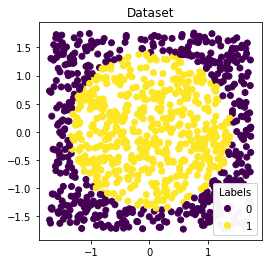

In [193]:
train_input, train_target = generate_disc_set(1000)
test_input, test_target = generate_disc_set(1000)

normalize_data(train_input)
normalize_data(test_input)
plot_dataset(train_input, train_target)

# Module Class

In [196]:
# heritage module definition
class Module(object):
    def __init__(self):
        super().__init__()
        self.lr = 0
    def forward(self, *input) :
        raise NotImplementedError
    def backward(self, *gradwrtoutput):
        raise NotImplementedError
    def param(self):
        return []

# activation functions

In [197]:
# Relu activation function
class ReLu(Module):
    def __init__(self ):
        super().__init__()
        self.save = 0
    def forward(self, x):
        y = x.clamp(min=0)
        self.save = x
        return y
    def backward(self, x):
        y = self.save > 0
        return y.float()*x
    def print(self):
        return

# tanh activation function
class Tanh(Module):
    def __init__(self, ):
        super().__init__()        
    def forward(self,x):
        y = (x.exp() - (-x).exp()) / ( x.exp() +  (-x).exp())
        return y
    def backward(self,x):
        y = 4*(x.exp() + x.mul(-1).exp()).pow(-2)
        return y
    def print(self):
        return

# MSE loss function

In [198]:
#MSE Loss implementation 
class LossMSE(Module):
    def __init__(self, ):
        super().__init__()
    def loss(self,y,y_pred):
        loss = (y_pred - y).pow(2).sum()
        return loss
    def grad(self,y,y_pred):
        return 2*(y_pred-y)

# Layers implementation

In [199]:
# Linear layer
class Linear(Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.x = torch.zeros(out_features)        
        self.in_features = in_features
        self.out_features = out_features
        self.weight = torch.rand(size=(self.in_features,self.out_features))
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        self.bias = torch.rand(self.out_features)
        self.bias.data.uniform_(-stdv, stdv)

    def print(self):
            print([self.weight.size(0),self.weight.size(1)])
            print(self.x.size(0))
    def print_weight(self):
        print(self.weight) 
    def update(self, grad):
        lr = self.lr
        self.weight = self.weight - lr*self.x.t().mm(grad) 
        self.bias = self.bias - lr*grad*1
    
    def backward(self, grad):
        b = grad.mm(self.weight.t())
        self.update(grad)
        return b
    def forward(self, x):
        self.x = x
        return x.mm(self.weight)+self.bias
    def set_Lr(self, lr):
        self.lr = lr
        return

# Sequential architecture

In [200]:
# Sequential architecture
class Sequential(Module):
    def __init__(self, param , loss):
        super().__init__()
        self.model = (param)
        self.loss = loss
    def forward(self, x):
        for _object in self.model:
            x = _object.forward(x)
        return x
    
    def backward(self, y, y_pred):
        Loss=self.loss.loss(y, y_pred)
        grad_pred = self.loss.grad(y, y_pred)
        for _object in reversed(self.model):
            grad_pred = _object.backward(grad_pred)
        return Loss
    def print(self):
        for _object in (self.model):
            _object.print()
    def set_Lr(self, lr=0):
        for _object in self.model:
            if isinstance(_object, Linear):
                _object.set_Lr(lr)

# Utils

In [253]:
def convert_to_one_hot_labels(input, target):
    tmp = input.new_zeros(target.size(0), target.max() + 1)
    tmp.scatter_(1, target.view(-1, 1), 1.0)
    return tmp

def compute_accuracy(model, data_features, data_target):
    output = model.forward(data_features.narrow(0, 0, data_features.size(0)))
    _, predicted_classes = torch.max(output.data, 1)
    nb_data_errors = sum(data_target.data.numpy() != predicted_classes.numpy())
    return nb_data_errors/data_features.size(0)*100

# Training

In [255]:
nb_epochs=100
mini_batch_size=1
Model = Sequential([Linear(2,128),ReLu(),Linear(128,2),ReLu()], LossMSE()) #Building the model and linking the loss
Model.set_Lr(0.01) #Setting the learning rate

#Print Parameters of the model
Model.print() 
print("Before training, Train Error: {:.4f}%, Test Error: {:.4f}%".format(compute_accuracy(Model, train_input, train_target), compute_accuracy(Model, test_input, test_target)))

train_target_one_hot= convert_to_one_hot_labels(train_input,train_target)
History_Loss=[]
for epochs in range(0,nb_epochs):
    Sum_Loss=0
    for b in range(0, train_input.size(0), 1):
        output = Model.forward(train_input.narrow(0, b, 1))
        Loss= Model.backward(train_target_one_hot.narrow(0, b, 1), output)
        Sum_Loss=Sum_Loss+Loss.item()
    History_Loss.append(Sum_Loss)  
    if epochs % 10 == 0:
        print("Epoch: {}, Train Error: {:.4f}%, Test Error: {:.4f}%, Loss  {:.4f}".format(epochs+1, compute_accuracy(Model, train_input, train_target), compute_accuracy(Model, test_input, test_target), Sum_Loss))

        
print("After training, Train Error: {:.4f}%, Test Error: {:.4f}%, Loss  {:.4f}".format(compute_accuracy(Model, train_input, train_target), compute_accuracy(Model, test_input, test_target), Sum_Loss))

[2, 128]
128
[128, 2]
2
Before training, Train Error: 46.3000%, Test Error: 44.9000%
Epoch: 1, Train Error: 9.5000%, Test Error: 9.2000%, Loss  291.5099
Epoch: 11, Train Error: 2.8000%, Test Error: 4.0000%, Loss  120.3267
Epoch: 21, Train Error: 2.3000%, Test Error: 4.1000%, Loss  105.3745
Epoch: 31, Train Error: 2.4000%, Test Error: 3.6000%, Loss  96.2990
Epoch: 41, Train Error: 2.3000%, Test Error: 3.3000%, Loss  89.2152
Epoch: 51, Train Error: 2.0000%, Test Error: 3.7000%, Loss  83.3758
Epoch: 61, Train Error: 1.9000%, Test Error: 3.3000%, Loss  78.4563
Epoch: 71, Train Error: 1.9000%, Test Error: 3.2000%, Loss  74.3540
Epoch: 81, Train Error: 1.8000%, Test Error: 3.2000%, Loss  70.5215
Epoch: 91, Train Error: 1.3000%, Test Error: 3.2000%, Loss  67.1722
After training, Train Error: 1.4000%, Test Error: 2.9000%, Loss  64.9169
